# Chapter 3 - Linear Regression

- [Load Datasets](#Load-Datasets)
- [3.1 Simple Linear Regression](#3.1-Simple-Linear-Regression)
- [3.2 Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
- [3.3 Other Considerations in the Regression Model](#3.3-Other-Considerations-in-the-Regression-Model)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

### Load Datasets
Datasets available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [2]:
advertising = pd.read_csv('Data/Advertising.csv', usecols=[1,2,3,4])
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


In [3]:
credit = pd.read_csv('Data/Credit.csv', usecols=list(range(1,12)))
credit['Student2'] = credit.Student.map({'No':0, 'Yes':1})
credit.head(3)

Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   14.891   3606     283      2   34         11    Male      No     Yes   
1  106.025   6645     483      3   82         15  Female     Yes     Yes   
2  104.593   7075     514      4   71         11    Male      No      No   

   Ethnicity  Balance  Student2  
0  Caucasian      333         0  
1      Asian      903         1  
2      Asian      580         0

In [4]:
auto = pd.read_csv('Data/Auto.csv', na_values='?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## 3.1 Simple Linear Regression

### Figure 3.1 - Least squares fit

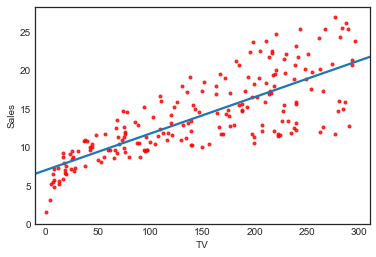

In [5]:
sns.regplot(advertising.TV, advertising.Sales, order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,310)
plt.ylim(ymin=0);

### Figure 3.2 - Regression coefficients - RSS
Note that the text in the book describes the coefficients based on uncentered data, whereas the plot shows the model based on centered data. The latter is visually more appealing for explaining the concept of a minimum RSS. I think that, in order not to confuse the reader, the values on the axis of the B0 coefficients have been changed to correspond with the text. The axes on the plots below are unaltered.

In [6]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1)
y = advertising.Sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

14.0225
[0.04753664]


In [7]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

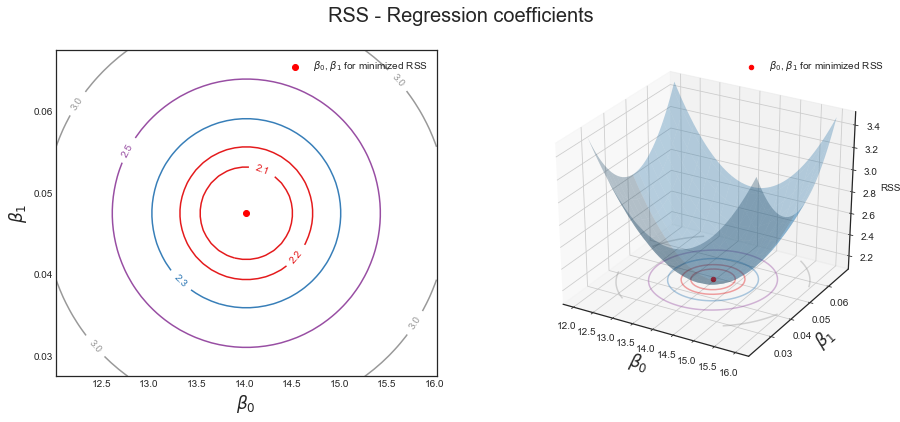

In [8]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Confidence interval on page 67 & Table 3.1 & 3.2 - Statsmodels 

In [9]:
est = smf.ols('Sales ~ TV', advertising).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [10]:
# RSS with regression coefficients
((advertising.Sales - (est.params[0] + est.params[1]*advertising.TV))**2).sum()/1000

2.1025305831313514

### Table 3.1 & 3.2 - Scikit-learn

In [11]:
regr = skl_lm.LinearRegression()

X = advertising.TV.values.reshape(-1,1)
y = advertising.Sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

7.032593549127693
[0.04753664]


In [12]:
Sales_pred = regr.predict(X)
r2_score(y, Sales_pred)

0.611875050850071

## 3.2 Multiple Linear Regression

### Table 3.3 - Statsmodels

In [13]:
est = smf.ols('Sales ~ Radio', advertising).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [14]:
est = smf.ols('Sales ~ Newspaper', advertising).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

### Table 3.4 & 3.6 - Statsmodels

In [15]:
est = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Tue, 09 Apr 2019   Prob (F-statistic):           1.58e-96
Time:                        13:38:06   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Table 3.5 - Correlation Matrix

In [16]:
advertising.corr()

TV     Radio  Newspaper     Sales
TV         1.000000  0.054809   0.056648  0.782224
Radio      0.054809  1.000000   0.354104  0.576223
Newspaper  0.056648  0.354104   1.000000  0.228299
Sales      0.782224  0.576223   0.228299  1.000000

### Figure 3.5 - Multiple Linear Regression

In [17]:
regr = skl_lm.LinearRegression()

X = advertising[['Radio', 'TV']].as_matrix()
y = advertising.Sales

regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)

[0.18799423 0.04575482]
2.9210999124051398


/Users/jitu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.
advertising[['Radio', 'TV']].describe()

Radio          TV
count  200.000000  200.000000
mean    23.264000  147.042500
std     14.846809   85.854236
min      0.000000    0.700000
25%      9.975000   74.375000
50%     22.900000  149.750000
75%     36.525000  218.825000
max     49.600000  296.400000

In [19]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(regr.intercept_ + B1[i,j]*regr.coef_[0] + B2[i,j]*regr.coef_[1])

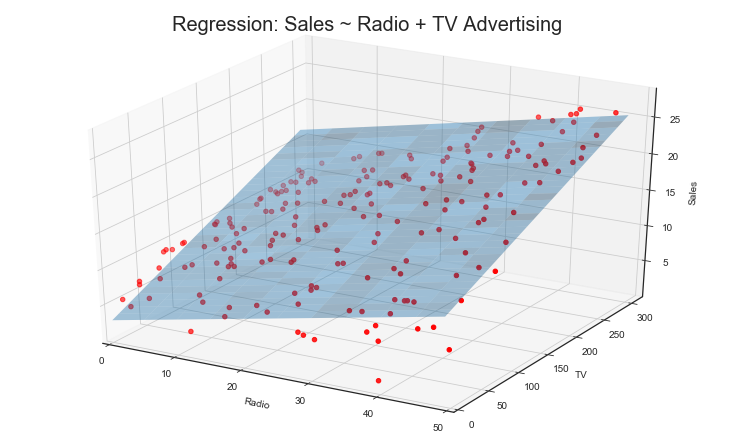

In [20]:
# Create plot
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: Sales ~ Radio + TV Advertising', fontsize=20)

ax = axes3d.Axes3D(fig)

ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(advertising.Radio, advertising.TV, advertising.Sales, c='r')

ax.set_xlabel('Radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(ymin=0)
ax.set_zlabel('Sales');

## 3.3 Other Considerations in the Regression Model

### Figure 3.6

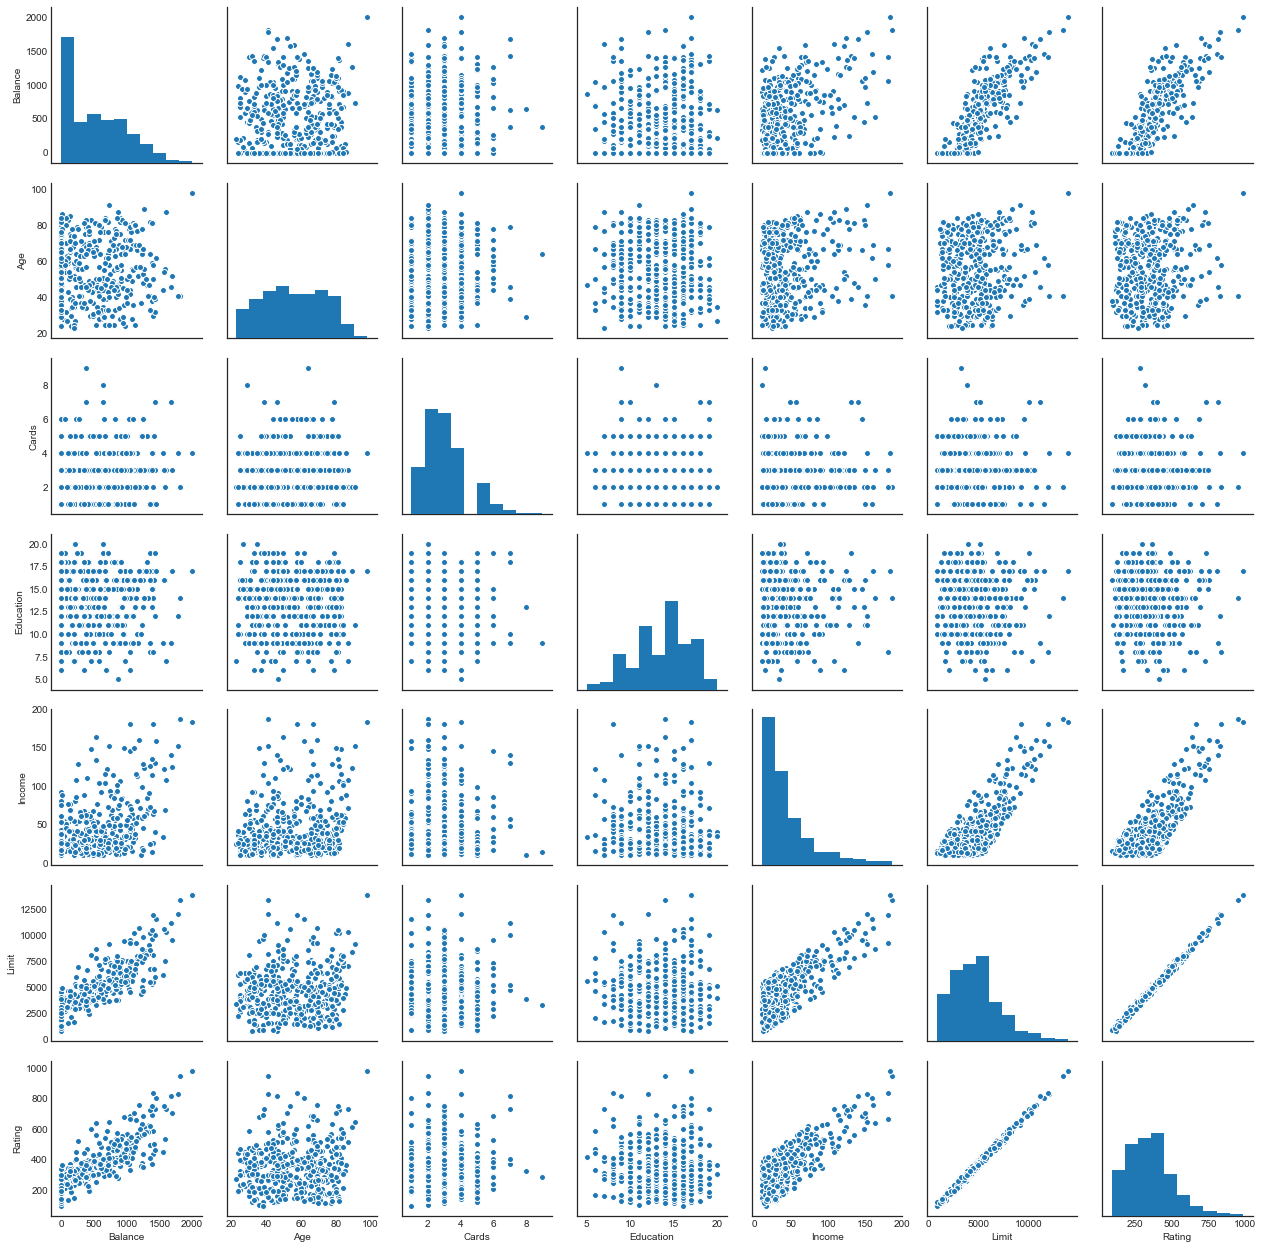

In [21]:
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']]);

###  Table 3.7

In [22]:
est = smf.ols('Balance ~ Gender', credit).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

### Table 3.8

In [23]:
est = smf.ols('Balance ~ Ethnicity', credit).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

### Table 3.9 - Interaction Variables

In [24]:
est = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

### Figure 3.7 - Interaction between qualitative and quantative variables

In [25]:
est1 = smf.ols('Balance ~ Income + Student2', credit).fit()
regr1 = est1.params
est2 = smf.ols('Balance ~ Income + Income*Student2', credit).fit()
regr2 = est2.params

print('Regression 1 - without interaction term')
print(regr1)
print('\nRegression 2 - with interaction term')
print(regr2)

Regression 1 - without interaction term
Intercept    211.142964
Income         5.984336
Student2     382.670539
dtype: float64

Regression 2 - with interaction term
Intercept          200.623153
Income               6.218169
Student2           476.675843
Income:Student2     -1.999151
dtype: float64


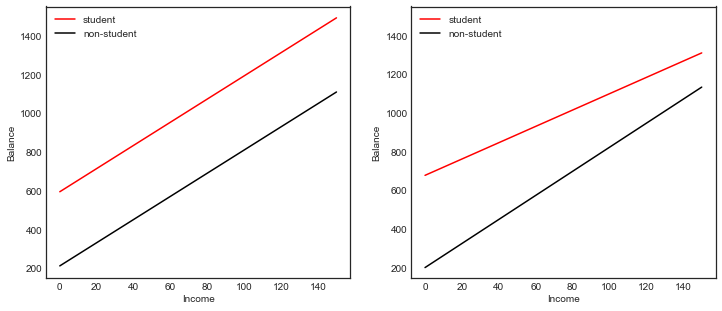

In [26]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(regr1['Intercept']+regr1['Student2'],
                       regr1['Intercept']+regr1['Student2']+150*regr1['Income'])
non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept']+150*regr1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept']+regr2['Student2'],
                       regr2['Intercept']+regr2['Student2']+
                       150*(regr2['Income']+regr2['Income:Student2']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept']+150*regr2['Income'])

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=2)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

### Figure 3.8 - Non-linear relationships

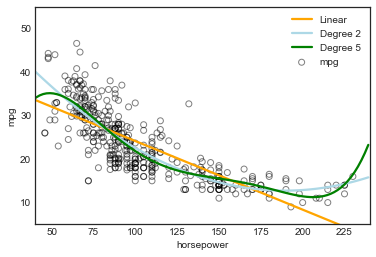

In [27]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(auto.horsepower, auto.mpg, facecolors='None', edgecolors='k', alpha=.5) 
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 5', order=5, scatter=False, color='g')
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

### Table 3.10

In [28]:
auto['horsepower2'] = auto.horsepower**2
auto.head(3)

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0    3504          12.0    70   
1  15.0          8         350.0       165.0    3693          11.5    70   
2  18.0          8         318.0       150.0    3436          11.0    70   

   origin                       name  horsepower2  
0       1  chevrolet chevelle malibu      16900.0  
1       1          buick skylark 320      27225.0  
2       1         plymouth satellite      22500.0

In [29]:
est = smf.ols('mpg ~ horsepower + horsepower2', auto).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

### Figure 3.9

In [30]:
regr = skl_lm.LinearRegression()

# Linear fit
X = auto.horsepower.values.reshape(-1,1)
y = auto.mpg
regr.fit(X, y)

auto['pred1'] = regr.predict(X)
auto['resid1'] = auto.mpg - auto.pred1

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']].as_matrix()
regr.fit(X2, y)

auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto.mpg - auto.pred2

/Users/jitu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


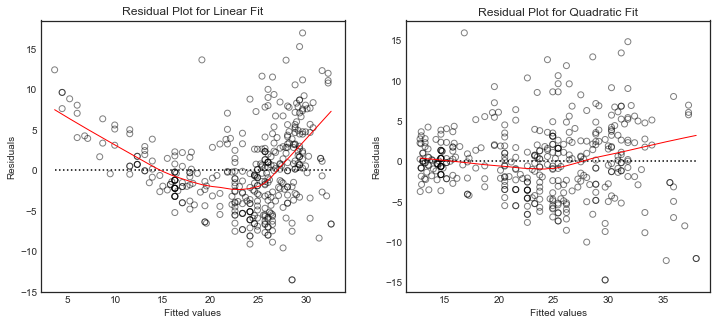

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
sns.regplot(auto.pred1, auto.resid1, lowess=True, 
            ax=ax1, line_kws={'color':'r', 'lw':1},
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

# Right plot
sns.regplot(auto.pred2, auto.resid2, lowess=True,
            line_kws={'color':'r', 'lw':1}, ax=ax2,
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

### Figure 3.14

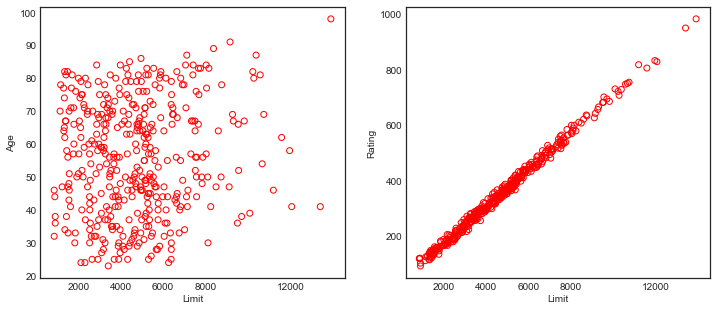

In [32]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.scatter(credit.Limit, credit.Age, facecolor='None', edgecolor='r')
ax1.set_ylabel('Age')

# Right plot
ax2.scatter(credit.Limit, credit.Rating, facecolor='None', edgecolor='r')
ax2.set_ylabel('Rating')

for ax in fig.axes:
    ax.set_xlabel('Limit')
    ax.set_xticks([2000,4000,6000,8000,12000])

### Figure 3.15

In [33]:
y = credit.Balance

# Regression for left plot
X = credit[['Age', 'Limit']].as_matrix()
regr1 = skl_lm.LinearRegression()
regr1.fit(scale(X.astype('float'), with_std=False), y)
print('Age/Limit\n',regr1.intercept_)
print(regr1.coef_)

# Regression for right plot
X2 = credit[['Rating', 'Limit']].as_matrix()
regr2 = skl_lm.LinearRegression()
regr2.fit(scale(X2.astype('float'), with_std=False), y)
print('\nRating/Limit\n',regr2.intercept_)
print(regr2.coef_)

Age/Limit
 520.0150000000001
[-2.29148553  0.17336497]

Rating/Limit
 520.015
[2.20167217 0.02451438]


/Users/jitu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/Users/jitu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [34]:
# Create grid coordinates for plotting
B_Age = np.linspace(regr1.coef_[0]-3, regr1.coef_[0]+3, 100)
B_Limit = np.linspace(regr1.coef_[1]-0.02, regr1.coef_[1]+0.02, 100)

B_Rating = np.linspace(regr2.coef_[0]-3, regr2.coef_[0]+3, 100)
B_Limit2 = np.linspace(regr2.coef_[1]-0.2, regr2.coef_[1]+0.2, 100)

X1, Y1 = np.meshgrid(B_Limit, B_Age, indexing='xy')
X2, Y2 = np.meshgrid(B_Limit2, B_Rating, indexing='xy')
Z1 = np.zeros((B_Age.size,B_Limit.size))
Z2 = np.zeros((B_Rating.size,B_Limit2.size))

Limit_scaled = scale(credit.Limit.astype('float'), with_std=False)
Age_scaled = scale(credit.Age.astype('float'), with_std=False)
Rating_scaled = scale(credit.Rating.astype('float'), with_std=False)

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z1):
    Z1[i,j] =((y - (regr1.intercept_ + X1[i,j]*Limit_scaled +
                    Y1[i,j]*Age_scaled))**2).sum()/1000000
    
for (i,j),v in np.ndenumerate(Z2):
    Z2[i,j] =((y - (regr2.intercept_ + X2[i,j]*Limit_scaled +
                    Y2[i,j]*Rating_scaled))**2).sum()/1000000

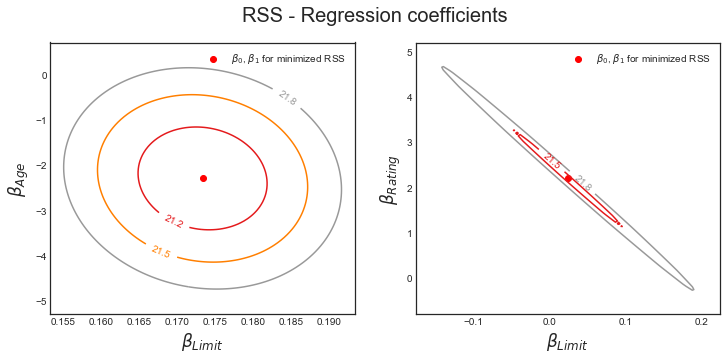

In [35]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
    
# Left plot
CS = ax1.contour(X1, Y1, Z1, cmap=plt.cm.Set1, levels=[21.25, 21.5, 21.8])
ax1.scatter(regr1.coef_[1], regr1.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax1.set_ylabel(r'$\beta_{Age}$', fontsize=17)

# Right plot
CS = ax2.contour(X2, Y2, Z2, cmap=plt.cm.Set1, levels=[21.5, 21.8])
ax2.scatter(regr2.coef_[1], regr2.coef_[0], c='r', label=min_RSS)
ax2.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax2.set_ylabel(r'$\beta_{Rating}$', fontsize=17)
ax2.set_xticks([-0.1, 0, 0.1, 0.2])

for ax in fig.axes:
    ax.set_xlabel(r'$\beta_{Limit}$', fontsize=17)
    ax.legend()

### Variance Inflation Factor - page 102

In [36]:
est_Age = smf.ols('Age ~ Rating + Limit', credit).fit()
est_Rating = smf.ols('Rating ~ Age + Limit', credit).fit()
est_Limit = smf.ols('Limit ~ Age + Rating', credit).fit()

print(1/(1-est_Age.rsquared))
print(1/(1-est_Rating.rsquared))
print(1/(1-est_Limit.rsquared))

1.0113846860681328
160.66830095856935
160.59287978597942


## Lab Linear Regression

In [37]:
## perform imports and set-up
import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy import stats
from matplotlib import pyplot as plt
from sklearn.datasets import load_boston # boston data set is part of sklearn
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('ggplot')

In [40]:
# Load Boston housing data set
boston = load_boston()

#Transform the data into a dataframe for analysisÂ¶

# combine the predictors and responses for a dataframe
predictors = boston.data
response = boston.target
boston_data = np.column_stack([predictors,response])

# now get the column names of the data frame
col_names = np.append(boston.feature_names, 'MEDV')

# create the data frame
boston_df = pd.DataFrame(boston_data, columns = col_names)
boston_df.head()

# Load the carseats data set
carseats_df = pd.read_csv('Data/Carseats.csv',index_col = 0)

## 3.6.2 Simple Linear Regression

#### We will regress LSTAT (% of households with low economic status) onto the MEDV (median home values). We will do this using two methods -- scipy.linregress and statsmodels. We will look at several diagnostics that describe the quality of the fit.

beta= [ 34.554 , -0.95 ]
R=-0.738, p_value=0.000, stderr=0.039


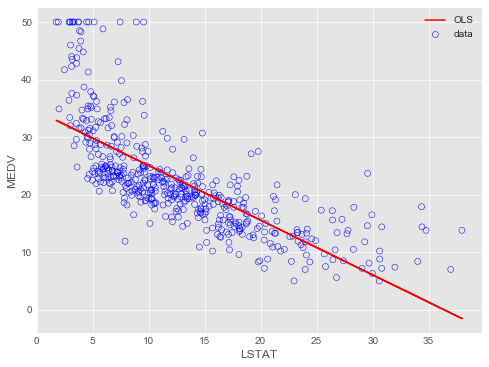

In [41]:
# Create a figure to plot our data and OLS estimate.
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(boston_df.LSTAT.values, boston_df.MEDV.values,facecolors='none', edgecolors='b',\
           label="data");
ax.set_ylabel('MEDV');
ax.set_xlabel('LSTAT');

# call scipy's linregress returning fit coefficients and simple statistics
beta1, beta0, r_value, p_value, stderr = stats.linregress(boston_df.LSTAT.values,\
                                                          boston_df.MEDV.values)

# add the estimation to the data plot
ax.plot(boston_df.LSTAT.values, beta0 + beta1*boston_df.LSTAT.values,color='r', label="OLS");
ax.legend(loc='best');

# print the regression estimates returned from scipy
print('beta= [',round(beta0,3),',', round(beta1,3),']')
print('R={0:.3f}, p_value={1:.3f}, stderr={2:.3f}'.format(r_value, p_value, stderr))

Regress LSTAT onto MEDV (Statemodels)

In [42]:
# Another method is to use the package statsmodels.

# Create a design matrix
# set the independent variable as the LSTAT
X = boston_df.LSTAT
# We add a constant for the intercept term
X = sm.add_constant(X)

# set the dependent variable
Y = boston_df.MEDV

# create the model instance and fit
linear_model = sm.OLS(Y,X)
linear_results = linear_model.fit()
# data about the model is stored in summary
print(linear_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Tue, 09 Apr 2019   Prob (F-statistic):           5.08e-88
Time:                        13:41:50   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.0

In [43]:
# statsmodels includes functions for getting the prediction and confidence intervals.

# Get prediction interval for a given x
prstd, iv_l, iv_u = wls_prediction_std(linear_results)

# statsmodels also includes the confidence intervals for the fitted values (i.e. the mean fits)
# but they are buried in the results of summary table function.
from statsmodels.stats.outliers_influence import summary_table

# call the summary table at a (1-alpha)100% confidence interval level
simpleTable, data, column_names = summary_table(linear_results, alpha=0.05)

# Data contains the confidence intervals we want but we need to make sure we get the right
# columns so lets print off the names
print('column_names: ', column_names)

# Get confidence intervals for a given x
predicted_mean_ci_low, predicted_mean_ci_high = data[:,4:6].T

column_names:  ['Obs', 'Dep Var\nPopulation', 'Predicted\nValue', 'Std Error\nMean Predict', 'Mean ci\n95% low', 'Mean ci\n95% upp', 'Predict ci\n95% low', 'Predict ci\n95% upp', 'Residual', 'Std Error\nResidual', 'Student\nResidual', "Cook's\nD"]


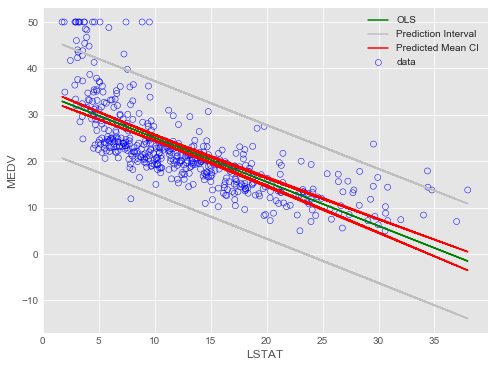

In [44]:
# Create a plot to plot the data, OLS estimate, prediction and confidence intervals
fig, ax = plt.subplots(figsize=(8,6))

# get numpy array values from dataframe
x = boston_df.LSTAT.values
y = boston_df.MEDV.values

# Plot the data
ax.scatter(x, y, facecolors='none', edgecolors='b', label="data")
# plot the models fitted values
ax.plot(x, linear_results.fittedvalues, 'g', label="OLS")

# plot the high and low prediction intervals
ax.plot(x, iv_u, color='0.75',label="Prediction Interval")
ax.plot(x, iv_l, color='0.75')

# plot the high and low mean confidence intervals
ax.plot(x,predicted_mean_ci_low, 'r', label="Predicted Mean CI")
ax.plot(x,predicted_mean_ci_high,'r')

ax.legend(loc='best');

plt.xlabel('LSTAT');
plt.ylabel('MEDV');

## Diagnostic plots for Linear Models

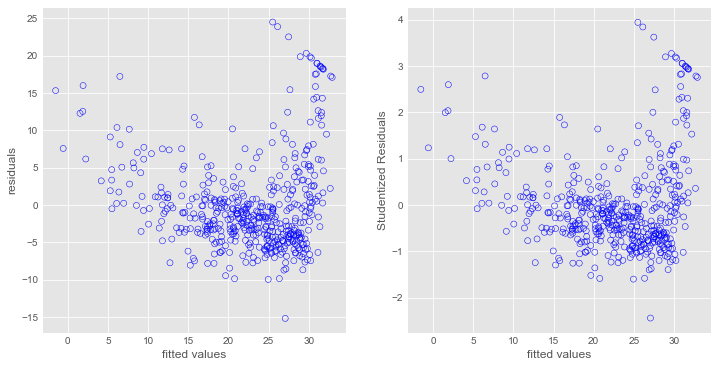

In [45]:
# Create plots of residuals
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

# RESIDUALS
# The results contain the residuals
fitted_values = linear_results.fittedvalues.values
residuals = linear_results.resid.values

# Plot the residual for each fitted value
ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b');
ax1.set_xlabel('fitted values');
ax1.set_ylabel('residuals');
# The residual plot indicates significant nonlinearity (a u-shape pattern is clear)

# STUDENTIZED RESIDUALS
# To asses data outliers we will look at the studentized residuals. This is in the data array 
# returned from summary table (10th column)
studentized_residuals = data[:,10]

# Plot the studentized residuals
ax2.scatter(fitted_values,studentized_residuals, facecolors='none', edgecolors='b');
ax2.set_ylabel('Studentized Residuals');
ax2.set_xlabel('fitted values');

# |studentized residual| > 3 are generally considered outliers

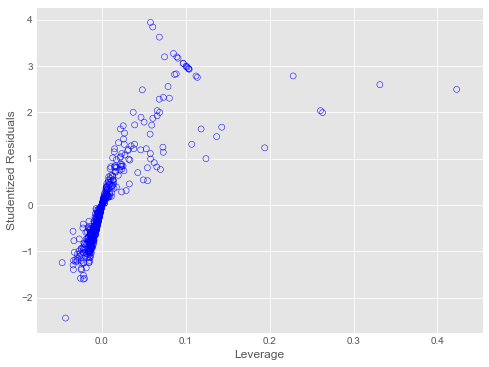

In [46]:
# We can also examine the leverages to identify points that may alter the regression line
from statsmodels.stats.outliers_influence import OLSInfluence
leverage = OLSInfluence(linear_results).influence

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(leverage, studentized_residuals,facecolors='none', edgecolors='b');
ax.set_xlabel('Leverage');
ax.set_ylabel('Studentized Residuals');

## Multiple Linear Regression
#### Here we will estimate MEDV using multiple linear regression. In the first example we will regress LSTAT and AGE onto MEDV.

Model parameters:
 const    33.222761
LSTAT    -1.032069
AGE       0.034544
dtype: float64


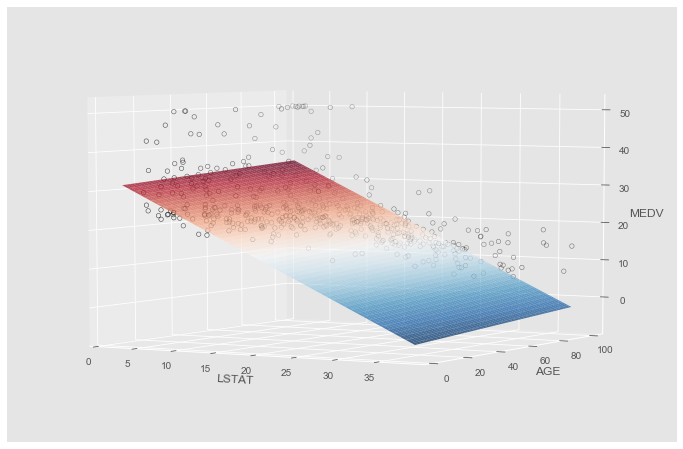

In [47]:
# create our design matrix using LSTAT and AGE predictors
X = sm.add_constant(boston_df[['LSTAT','AGE']])

# set the dependent variable
Y = boston_df.MEDV

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d',azim=-60, elev=5)

# create the model instance and estimate
model = sm.OLS(Y,X)
estimate = model.fit()
# data about the model is stored in summary
print('Model parameters:\n', estimate.params[:])

# Plot the data
ax.scatter(X.loc[:,'LSTAT'], X.loc[:,'AGE'], Y.values, facecolors=(0,0,0,0),\
           edgecolor='k', depthshade=True);
ax.set_xlabel('LSTAT');
ax.set_ylabel('AGE')
ax.set_zlabel('MEDV')

# Plot the OLS estimate
# create a grid of points
xx1, xx2 = np.meshgrid(np.linspace(X.LSTAT.min(), X.LSTAT.max(), 100), 
                       np.linspace(X.AGE.min(), X.AGE.max(), 100))

# plot the plane by evaluating the parameters over the grid
Z = estimate.params[0] + estimate.params[1] * xx1 + estimate.params[2] * xx2
# plot plane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.75, linewidth=0)


Now we will perform the regression over all 13 predictors in the boston housing dataset.

In [48]:
# create our design matrix using all the predictors (last column is MEDV)
X = sm.add_constant(boston_df.iloc[:,0:-1])

# create the model instance and estimate
model = sm.OLS(Y,X)
est = model.fit()
# data about the model is stored in summary
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 09 Apr 2019   Prob (F-statistic):          6.95e-135
Time:                        13:44:52   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4911      5.104      7.149      0.0

In [49]:
# Compute all the variance inflation factors
from statsmodels.stats.outliers_influence import variance_inflation_factor

VIFs = [(predictor, variance_inflation_factor(X.values,_)) \
        for _,predictor in enumerate(list(X))] # list(X) returns column names of df

print('Variance Inflation Factors')
for tup in VIFs:
    print('{:10}'.format(tup[0]), '{:.3f}'.format(tup[1]))

Variance Inflation Factors
const      585.425
CRIM       1.773
ZN         2.299
INDUS      3.991
CHAS       1.074
NOX        4.395
RM         1.934
AGE        3.101
DIS        3.957
RAD        7.481
TAX        9.008
PTRATIO    1.799
B          1.346
LSTAT      2.938


## Interaction Terms

Statsmodels uses the patsy package to convert formulas to matrices for fitting. This allows for easy implementation of arbitrary functions of the predictors.

In [50]:
import statsmodels.formula.api as smf

# Construct model and fit
model = smf.ols(formula='MEDV ~ LSTAT*AGE', data=boston_df)
estimate = model.fit()
print(estimate.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Tue, 09 Apr 2019   Prob (F-statistic):           4.86e-88
Time:                        13:45:53   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.0885      1.470     24.553      0.0

## Non-linear Transformation of the Predictors

Statsmodel patsy api allows us to include non-linear terms

In [51]:
model = smf.ols('MEDV ~ LSTAT + I(LSTAT**2)', data=boston_df)
quadratic_results = model.fit()
print(quadratic_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Tue, 09 Apr 2019   Prob (F-statistic):          1.56e-112
Time:                        13:46:41   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        42.8620      0.872     49.149

The near zero p-value for the quadratic term suggest an improved model. We will plot and perform some diagnostics of the fit.

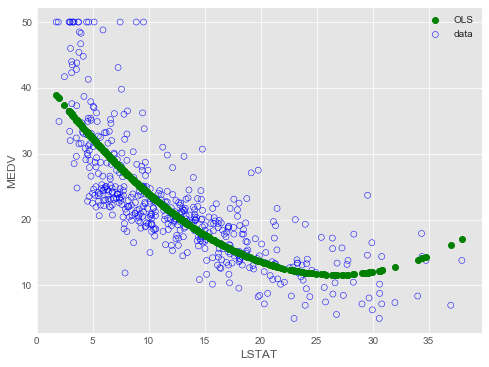

In [52]:
fig, ax = plt.subplots(figsize=(8,6))

# get numpy array values from dataframe
x = boston_df.LSTAT.values
y = boston_df.MEDV.values

# Plot the data
ax.scatter(x, y, facecolors='none', edgecolors='b', label="data");
# plot the models fitted values
ax.plot(x, quadratic_results.fittedvalues, 'g', marker='o',linestyle='none', label="OLS");

ax.legend(loc='best');

plt.xlabel('LSTAT');
plt.ylabel('MEDV');

In [53]:
# Diagnostic tests of quadratic estimate

# import anova function
from statsmodels.stats.api import anova_lm

# perform the hypothesis test (see https://en.wikipedia.org/wiki/F-test regression section)
anova_table = anova_lm(linear_results, quadratic_results)
print(anova_table)

   df_resid           ssr  df_diff     ss_diff           F        Pr(>F)
0     504.0  19472.381418      0.0         NaN         NaN           NaN
1     503.0  15347.243158      1.0  4125.13826  135.199822  7.630116e-28


/Users/jitu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/jitu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/jitu/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


#### The F-statistic is 135 with a p-value of ~0 indicating there is a large difference in the unexplained variances of the two models. This is not too suprising given the plot above. Now consider the residuals.

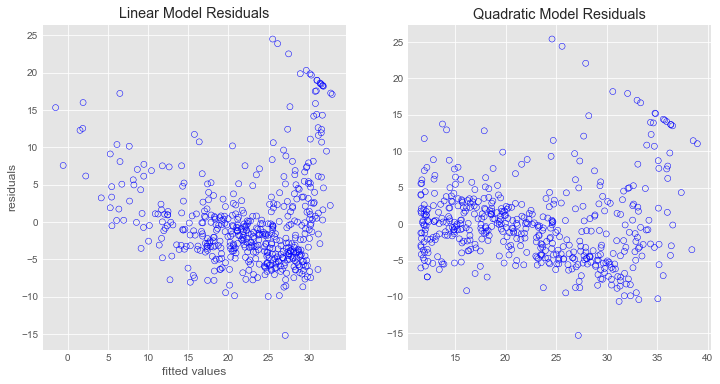

In [55]:
# Create plots of residuals
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

# RESIDUALS OF LINEAR MODEL
# The results contain the residuals
linear_fit_values = linear_results.fittedvalues.values
residuals = linear_results.resid.values

# Plot the residual for each fitted value for the linear model
ax1.scatter(linear_fit_values, residuals, facecolors='none', edgecolors='b');
ax1.set_xlabel('fitted values');
ax1.set_ylabel('residuals');
ax1.set_title('Linear Model Residuals')

# RESIDUALS OF QUADRATIC MODEL
# The results contain the residuals
quadratic_fit_values = quadratic_results.fittedvalues.values
quadratic_residuals = quadratic_results.resid.values
ax2.scatter(quadratic_fit_values, quadratic_residuals, facecolors='none', edgecolors='b');
ax2.set_title('Quadratic Model Residuals');

In [56]:
# we can also try higher order polynomial fits

formula = 'MEDV ~ 1 + ' + ' + '.join('I(LSTAT**{})'.format(i) for i in range(1, 6))
print(formula)
model = smf.ols(formula, data=boston_df)
order_5_results = model.fit()
print(order_5_results.summary())

MEDV ~ 1 + I(LSTAT**1) + I(LSTAT**2) + I(LSTAT**3) + I(LSTAT**4) + I(LSTAT**5)
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     214.2
Date:                Tue, 09 Apr 2019   Prob (F-statistic):          8.73e-122
Time:                        13:50:37   Log-Likelihood:                -1550.6
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

## Qualitative Predictors

In [57]:
carseats_df.head()

Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
1   9.50        138      73           11         276    120       Bad   42   
2  11.22        111      48           16         260     83      Good   65   
3  10.06        113      35           10         269     80    Medium   59   
4   7.40        117     100            4         466     97    Medium   55   
5   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
1         17   Yes  Yes  
2         10   Yes  Yes  
3         12   Yes  Yes  
4         14   Yes  Yes  
5         13   Yes   No

In [58]:
# Construct the formula with two interaction terms
formula ='Sales ~' + '+'.join(list(carseats_df.iloc[:,1:].columns.tolist()) + ['Income:Advertising'] + ['Price:Age'])
print(formula)

print()

model = smf.ols(formula, data=carseats_df)
carseat_results = model.fit()
print(carseat_results.summary())

Sales ~CompPrice+Income+Advertising+Population+Price+ShelveLoc+Age+Education+Urban+US+Income:Advertising+Price:Age

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Tue, 09 Apr 2019   Prob (F-statistic):          6.14e-166
Time:                        13:51:15   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------

References - https://github.com/JWarmenhoven/ISLR-python